In [1]:
import string

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from scnn.sh import isft, n_coeffs

sns.set_theme()

BATCH_SIZE = int(5e2)

In [2]:
# MSE

targets = torch.load("../test_targets.pt")
odf_targets = torch.zeros(len(targets), len(isft))
for i in range(0, len(targets), BATCH_SIZE):
    idx = torch.arange(i, i + BATCH_SIZE)
    odf_targets[idx] = (
        isft
        @ torch.nn.functional.pad(targets[idx, 0:45], (0, n_coeffs - 45)).unsqueeze(-1)
    ).squeeze(-1)

for fname in [
    "scnn_preds.pt",
    "scnn_preds_rot.pt",
    "smt_preds.pt",
    "mlp_preds.pt",
    "mlp_preds_rot.pt",
]:
    preds = torch.load(f"../{fname}")
    odf_preds = torch.zeros(len(preds), len(isft))
    for i in range(0, len(preds), BATCH_SIZE):
        idx = torch.arange(i, i + BATCH_SIZE)
        odf_preds[idx] = (
            isft
            @ torch.nn.functional.pad(preds[idx, 0:45], (0, n_coeffs - 45)).unsqueeze(
                -1
            )
        ).squeeze(-1)

    print(fname)
    print(f"ODF: {((odf_targets[:, -2] - odf_preds[:, -2]) ** 2).mean().item() * 1e3}")
    print(f"d:   {((targets[:, -2] - preds[:, -2]) ** 2).mean().item() * 1e3}")
    print(f"f:   {((targets[:, -1] - preds[:, -1]) ** 2).mean().item() * 1e3}")
    print("")

    del preds, odf_preds

scnn_preds.pt
ODF: 2.759348601102829
d:   3.0806842260062695
f:   3.2287549693137407

scnn_preds_rot.pt
ODF: 2.7515313122421503
d:   3.0657139141112566
f:   3.231544978916645

smt_preds.pt
ODF: 6.472265813499689
d:   10.92379167675972
f:   37.500254809856415

mlp_preds.pt
ODF: 2.7128926012665033
d:   4.004952032119036
f:   3.7016323767602444

mlp_preds_rot.pt
ODF: 2.6984447613358498
d:   3.9955531246960163
f:   3.6319526843726635



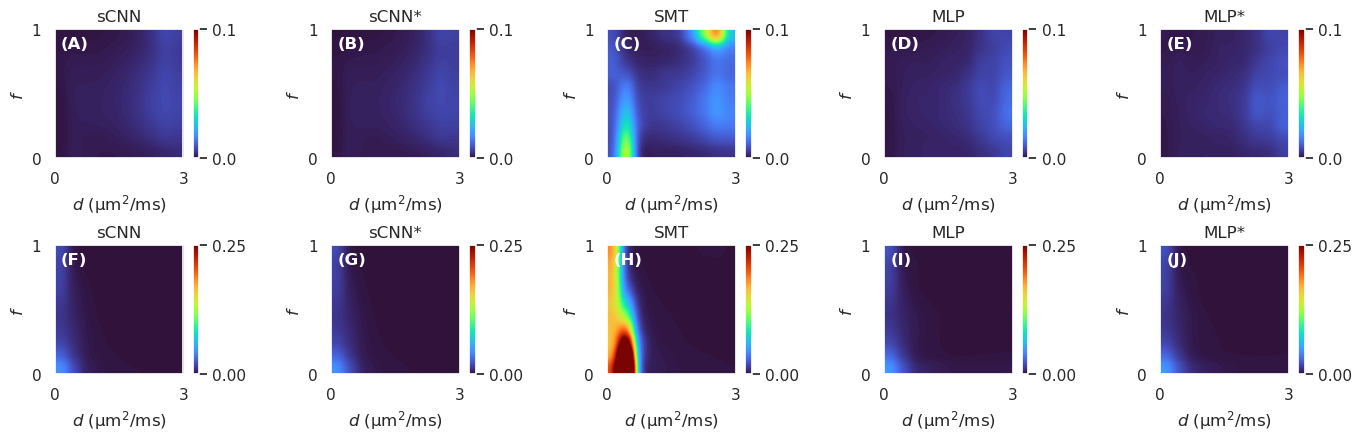

In [3]:
# MSE for different values of d and f

alphabet = list(string.ascii_uppercase)
bins = [10, 10]
x = targets[:, -2]
y = targets[:, -1]

fig, ax = plt.subplots(2, 5, figsize=(14, 4.5))

for i, (fname, model_name) in enumerate(
    zip(
        [
            "scnn_preds.pt",
            "scnn_preds_rot.pt",
            "smt_preds.pt",
            "mlp_preds.pt",
            "mlp_preds_rot.pt",
        ],
        [
            "sCNN",
            "sCNN*",
            "SMT",
            "MLP",
            "MLP*",
        ],
    )
):
    preds = torch.load(f"../{fname}")
    for j in range(2):
        se = (targets[:, -(2 - j)] - preds[:, -(2 - j)]) ** 2
        hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins, weights=se)
        hist_count, _, _ = np.histogram2d(x, y, bins=bins)
        hist_avg = hist / hist_count
        if j == 0:
            im = ax[j, i].imshow(
                hist_avg.T,
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                aspect=3,
                cmap="turbo",
                interpolation="gaussian",
                vmin=0,
                vmax=0.1,
            )
            cbar = plt.colorbar(im, ax=ax[j, i])
            cbar.set_ticks([0, 0.1])
        else:
            im = ax[j, i].imshow(
                hist_avg.T,
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                aspect=3,
                cmap="turbo",
                interpolation="gaussian",
                vmin=0,
                vmax=0.25,
            )
            cbar = plt.colorbar(im, ax=ax[j, i])
            cbar.set_ticks([0, 0.25])
        ax[j, i].set_xticks([0, 3])
        ax[j, i].set_yticks([0, 1])
        ax[j, i].text(
            0.05,
            0.95,
            f"({alphabet[i + 5]})" if j == 1 else f"({alphabet[i]})",
            transform=ax[j, i].transAxes,
            fontsize=12,
            verticalalignment="top",
            color="white",
            weight="bold",
        )
        ax[j, i].set_title(model_name)
        ax[j, i].set_xlabel(r"$d$ (μm$^2$/ms)")
        ax[j, i].set_ylabel(r"$f$")
        ax[j, i].grid(False)
fig.tight_layout()
plt.show()
fig.savefig("se.png", dpi=300)